In [2]:
import os, math, random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from keras_hub.models import ViTImageClassifier

from sklearn.metrics import classification_report, confusion_matrix
import itertools

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [3]:
DATA_ROOT = "./processed"
RESULTS_DIR = "./results_vit"
os.makedirs(RESULTS_DIR, exist_ok=True)

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15
VAL_SPLIT = 0.20
TEST_SPLIT_FROM_VAL = 0.5

AUTOTUNE = tf.data.AUTOTUNE

## Load Data & Split Data

In [4]:
# Load train+val from directory
full_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_ROOT,
    label_mode="int",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=VAL_SPLIT,
    subset="both",
    seed=42,
)

train_ds, val_ds_raw = full_ds
class_names = train_ds.class_names
NUM_CLASSES = len(class_names)
print("Classes:", class_names)
print("Number of classes:", NUM_CLASSES)

Found 42385 files belonging to 13 classes.
Using 33908 files for training.
Using 8477 files for validation.
Classes: ['Academic_Art', 'Art_Nouveau', 'Baroque', 'Expressionism', 'Japanese_Art', 'Neoclassicism', 'Primitivism', 'Realism', 'Renaissance', 'Rococo', 'Romanticism', 'Symbolism', 'Western_Medieval']
Number of classes: 13


In [5]:
# Split val into val + test
val_batches = tf.data.experimental.cardinality(val_ds_raw)
test_ds = val_ds_raw.take(val_batches // 2)
val_ds  = val_ds_raw.skip(val_batches // 2)

print("Train batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Val batches:", tf.data.experimental.cardinality(val_ds).numpy())
print("Test batches:", tf.data.experimental.cardinality(test_ds).numpy())

Train batches: 1060
Val batches: 133
Test batches: 132


In [12]:
# Data augmentation (used inside the ViT model)
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.05)
    ],
    name="data_augmentation"
)

def prepare_dataset(ds, shuffle=False, augment=False):
    def apply_augment(x, y):
        x = tf.cast(x, tf.float32) / 255.0
        if augment:
            x = data_augmentation(x)
        return x, y
    ds = ds.map(apply_augment, num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    return ds.prefetch(AUTOTUNE)

train_ds_prep = prepare_dataset(train_ds, shuffle=True, augment=True)
val_ds_prep   = prepare_dataset(val_ds, shuffle=False, augment=False)
test_ds_prep  = prepare_dataset(test_ds, shuffle=False, augment=False)

## Build Vision Transformer Model

In [14]:
# Callbacks
checkpoint_path = os.path.join(RESULTS_DIR, "vit_best.keras")
callbacks = [
    keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=False,
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        min_lr=1e-6,
    ),
]

In [16]:
vit_pre_model = ViTImageClassifier.from_preset(
    "vit_base_patch16_224_imagenet",
    num_classes=NUM_CLASSES,
    preprocessor=None,
)

vit_pre_model.backbone.trainable = False

vit_pre_model.compile(
    optimizer=keras.optimizers.Adam(5e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

vit_pre_model.summary()

Model: "vi_t_image_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                       ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ images (InputLayer)                           │ (None, 224, 224, 3)                │                   0 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ vi_t_backbone (ViTBackbone)                   │ (None, 197, 768)                   │          85,798,656 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ get_item (GetItem)                            │ (None, 768)                        │                   0 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ output_dropout (Dropout)                      │ (None, 768)                        │                   0 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ predictions (Dense)                           │ (None, 13)                         │               9,997 │
└───────────────────────────────────────────────┴────────────────────────────────────┴─────────────────────┘

 Total params: 85,808,653 (327.33 MB)

 Trainable params: 9,997 (39.05 KB)

 Non-trainable params: 85,798,656 (327.30 MB)

In [18]:
history_vit_pre = vit_pre_model.fit(
    train_ds_prep,
    validation_data=val_ds_prep,
    epochs=EPOCHS,
    callbacks=callbacks,
)

Epoch 1/15


2025-12-07 14:09:54.395455: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:23: Filling up shuffle buffer (this may take a while): 744 of 1000
2025-12-07 14:09:57.862226: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1060/1060 ━━━━━━━━━━━━━━━━━━━━ 3648s 3s/step - accuracy: 0.2493 - loss: 2.3505 - val_accuracy: 0.3289 - val_loss: 2.0593 - learning_rate: 5.0000e-05
Epoch 2/15


2025-12-07 15:10:40.115774: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:23: Filling up shuffle buffer (this may take a while): 619 of 1000
2025-12-07 15:10:46.171693: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1060/1060 ━━━━━━━━━━━━━━━━━━━━ 3580s 3s/step - accuracy: 0.3777 - loss: 1.8889 - val_accuracy: 0.4037 - val_loss: 1.8102 - learning_rate: 5.0000e-05
Epoch 3/15


2025-12-07 16:10:19.865490: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:23: Filling up shuffle buffer (this may take a while): 633 of 1000
2025-12-07 16:10:25.908094: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1060/1060 ━━━━━━━━━━━━━━━━━━━━ 3616s 3s/step - accuracy: 0.4346 - loss: 1.7057 - val_accuracy: 0.4472 - val_loss: 1.6665 - learning_rate: 5.0000e-05
Epoch 4/15


2025-12-07 17:10:36.261712: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:23: Filling up shuffle buffer (this may take a while): 639 of 1000
2025-12-07 17:10:42.134394: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1060/1060 ━━━━━━━━━━━━━━━━━━━━ 3572s 3s/step - accuracy: 0.4696 - loss: 1.5990 - val_accuracy: 0.4721 - val_loss: 1.5806 - learning_rate: 5.0000e-05
Epoch 5/15


2025-12-07 18:10:07.961265: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:23: Filling up shuffle buffer (this may take a while): 647 of 1000
2025-12-07 18:10:13.866141: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1060/1060 ━━━━━━━━━━━━━━━━━━━━ 3572s 3s/step - accuracy: 0.4973 - loss: 1.5215 - val_accuracy: 0.4928 - val_loss: 1.5205 - learning_rate: 5.0000e-05
Epoch 6/15


2025-12-07 19:09:40.411627: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:23: Filling up shuffle buffer (this may take a while): 650 of 1000
2025-12-07 19:09:46.380210: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1060/1060 ━━━━━━━━━━━━━━━━━━━━ 3587s 3s/step - accuracy: 0.5139 - loss: 1.4669 - val_accuracy: 0.5095 - val_loss: 1.4677 - learning_rate: 5.0000e-05
Epoch 7/15


2025-12-07 20:09:27.829052: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:23: Filling up shuffle buffer (this may take a while): 607 of 1000
2025-12-07 20:09:34.581312: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1060/1060 ━━━━━━━━━━━━━━━━━━━━ 3713s 3s/step - accuracy: 0.5336 - loss: 1.4170 - val_accuracy: 0.5208 - val_loss: 1.4309 - learning_rate: 5.0000e-05
Epoch 8/15


2025-12-07 21:11:21.043620: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:23: Filling up shuffle buffer (this may take a while): 524 of 1000
2025-12-07 21:11:30.008428: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1060/1060 ━━━━━━━━━━━━━━━━━━━━ 3734s 4s/step - accuracy: 0.5425 - loss: 1.3815 - val_accuracy: 0.5276 - val_loss: 1.4021 - learning_rate: 5.0000e-05
Epoch 9/15


2025-12-07 22:13:34.956547: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:23: Filling up shuffle buffer (this may take a while): 595 of 1000
2025-12-07 22:13:42.171198: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1060/1060 ━━━━━━━━━━━━━━━━━━━━ 3616s 3s/step - accuracy: 0.5523 - loss: 1.3529 - val_accuracy: 0.5396 - val_loss: 1.3748 - learning_rate: 5.0000e-05
Epoch 10/15


2025-12-07 23:13:50.451392: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:23: Filling up shuffle buffer (this may take a while): 644 of 1000
2025-12-07 23:13:56.317150: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1060/1060 ━━━━━━━━━━━━━━━━━━━━ 3582s 3s/step - accuracy: 0.5617 - loss: 1.3259 - val_accuracy: 0.5467 - val_loss: 1.3612 - learning_rate: 5.0000e-05
Epoch 11/15


2025-12-08 00:13:32.526973: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:23: Filling up shuffle buffer (this may take a while): 647 of 1000
2025-12-08 00:13:38.081298: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1060/1060 ━━━━━━━━━━━━━━━━━━━━ 3574s 3s/step - accuracy: 0.5701 - loss: 1.3068 - val_accuracy: 0.5523 - val_loss: 1.3380 - learning_rate: 5.0000e-05
Epoch 12/15


2025-12-08 01:13:06.893832: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:23: Filling up shuffle buffer (this may take a while): 624 of 1000
2025-12-08 01:13:13.087956: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1060/1060 ━━━━━━━━━━━━━━━━━━━━ 3588s 3s/step - accuracy: 0.5742 - loss: 1.2887 - val_accuracy: 0.5584 - val_loss: 1.3219 - learning_rate: 5.0000e-05
Epoch 13/15


2025-12-08 02:12:55.022208: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:23: Filling up shuffle buffer (this may take a while): 632 of 1000
2025-12-08 02:13:00.985457: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1060/1060 ━━━━━━━━━━━━━━━━━━━━ 3536s 3s/step - accuracy: 0.5799 - loss: 1.2684 - val_accuracy: 0.5601 - val_loss: 1.3110 - learning_rate: 5.0000e-05
Epoch 14/15


2025-12-08 03:11:51.269204: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:23: Filling up shuffle buffer (this may take a while): 625 of 1000
2025-12-08 03:11:57.594969: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1060/1060 ━━━━━━━━━━━━━━━━━━━━ 3569s 3s/step - accuracy: 0.5848 - loss: 1.2524 - val_accuracy: 0.5624 - val_loss: 1.3015 - learning_rate: 5.0000e-05
Epoch 15/15


2025-12-08 04:11:19.948416: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:23: Filling up shuffle buffer (this may take a while): 633 of 1000
2025-12-08 04:11:26.264998: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1060/1060 ━━━━━━━━━━━━━━━━━━━━ 3558s 3s/step - accuracy: 0.5915 - loss: 1.2411 - val_accuracy: 0.5660 - val_loss: 1.2871 - learning_rate: 5.0000e-05


In [21]:
SAVE_DIR = "./models"
os.makedirs(SAVE_DIR, exist_ok=True)
SAVED_MODEL_DIR = './models/art_style_vit.keras'

vit_pre_model.save(SAVED_MODEL_DIR)

print(f"Model saved successfully to directory: {os.path.abspath(SAVED_MODEL_DIR)}")

Model saved successfully to directory: /Users/superman/Desktop/UofT/AI & Deep Learning/RSM8421_Project/models/art_style_vit.keras


### Observe training process of ViT

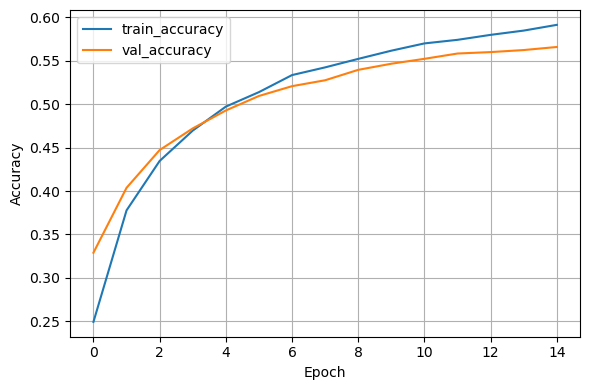

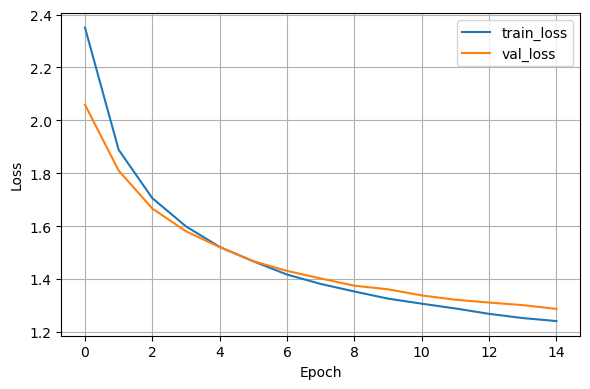

In [23]:
def plot_history(history, metric="accuracy"):
    plt.figure(figsize=(6,4))
    plt.plot(history.history[metric], label=f"train_{metric}")
    plt.plot(history.history[f"val_{metric}"], label=f"val_{metric}")
    plt.xlabel("Epoch")
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_history(history_vit_pre, metric="accuracy")
plot_history(history_vit_pre, metric="loss")

Classification report (ViT):
                  precision    recall  f1-score   support

    Academic_Art       0.65      0.33      0.44       137
     Art_Nouveau       0.63      0.62      0.62       304
         Baroque       0.56      0.44      0.49       535
   Expressionism       0.56      0.77      0.65       273
    Japanese_Art       0.83      0.69      0.76       226
   Neoclassicism       0.69      0.44      0.54       324
     Primitivism       0.64      0.54      0.59       124
         Realism       0.64      0.56      0.60       552
     Renaissance       0.52      0.77      0.62       593
          Rococo       0.49      0.44      0.46       243
     Romanticism       0.49      0.60      0.54       656
       Symbolism       0.25      0.14      0.18       146
Western_Medieval       0.81      0.80      0.81       111

        accuracy                           0.57      4224
       macro avg       0.60      0.55      0.56      4224
    weighted avg       0.58      0.57    

2025-12-08 12:16:52.411935: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


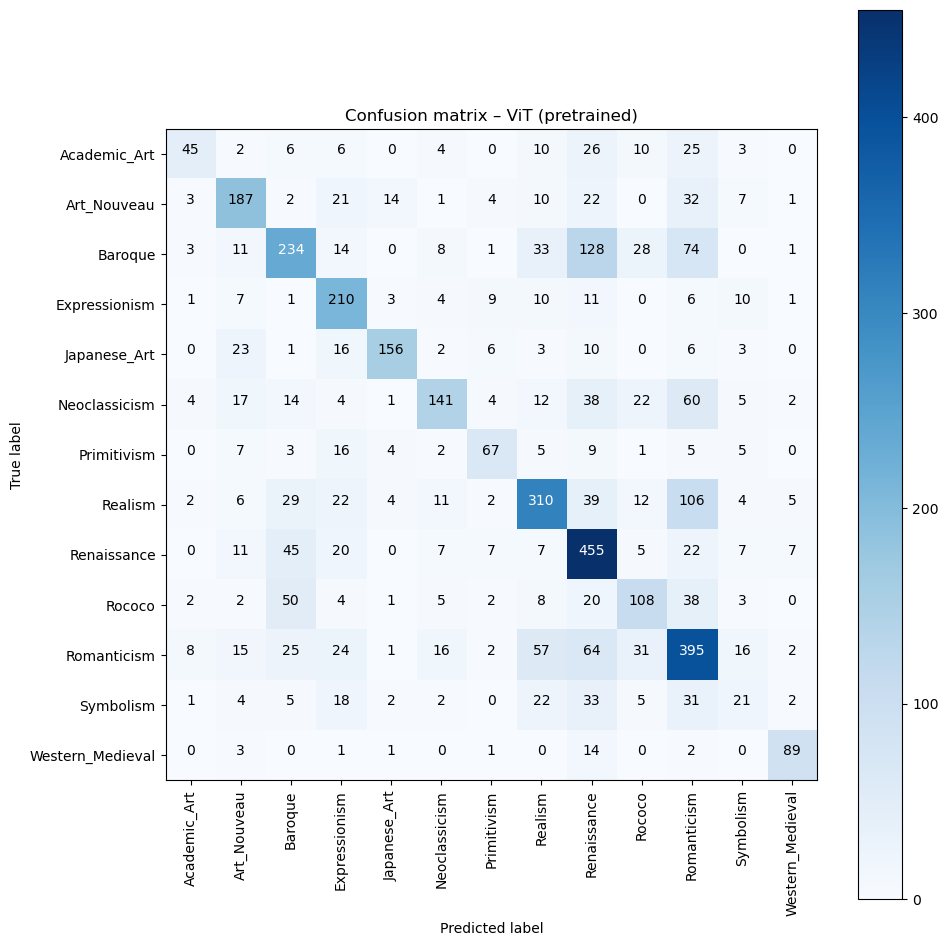

In [25]:
# Get predictions
y_true = []
y_pred = []

for batch_images, batch_labels in test_ds_prep:
    preds = vit_pre_model.predict(batch_images, verbose=0)
    y_true.extend(batch_labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
print("Classification report (ViT):")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix – ViT (pretrained)")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(
        j,
        i,
        format(cm[i, j], "d"),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black",
    )

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

### Observe training process of Baseline CNN

In [49]:
cnn_model = keras.models.load_model("./models/art_style_cnn")

In [51]:
cnn_test_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_ROOT,
    label_mode="int",
    image_size=(512, 512),  # same as training
    batch_size=BATCH_SIZE,
    shuffle=False,
)

cnn_test_ds = cnn_test_ds.prefetch(tf.data.AUTOTUNE)

Found 42385 files belonging to 13 classes.


Classification report (ViT):
                  precision    recall  f1-score   support

    Academic_Art       0.92      0.80      0.86      1300
     Art_Nouveau       0.89      0.88      0.88      3031
         Baroque       0.85      0.88      0.86      5295
   Expressionism       0.86      0.83      0.84      2606
    Japanese_Art       0.91      0.90      0.90      2231
   Neoclassicism       0.94      0.88      0.91      3110
     Primitivism       0.88      0.86      0.87      1300
         Realism       0.85      0.87      0.86      5353
     Renaissance       0.86      0.89      0.88      6183
          Rococo       0.85      0.88      0.86      2519
     Romanticism       0.86      0.89      0.88      6789
       Symbolism       0.92      0.79      0.85      1510
Western_Medieval       0.95      0.82      0.88      1158

        accuracy                           0.87     42385
       macro avg       0.89      0.86      0.87     42385
    weighted avg       0.87      0.87    

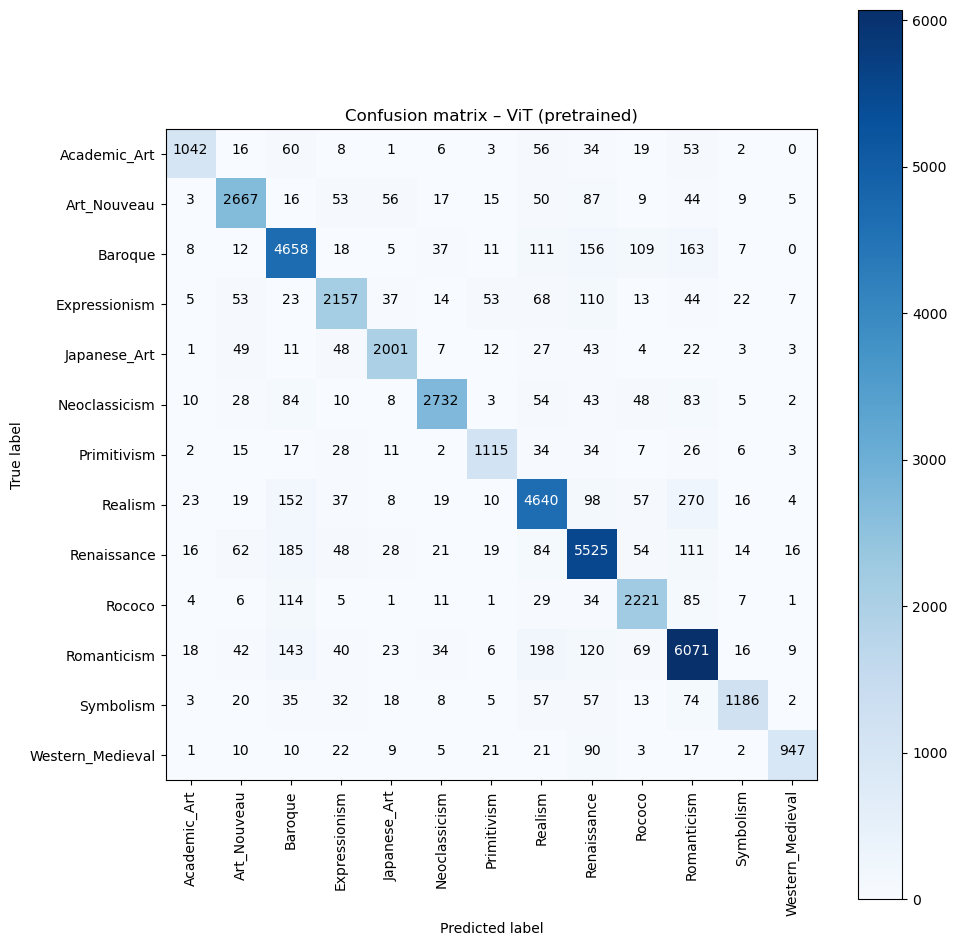

In [53]:
# Get predictions
y_true = []
y_pred = []

for batch_images, batch_labels in cnn_test_ds:
    preds = cnn_model.predict(batch_images, verbose=0)
    y_true.extend(batch_labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
print("Classification report (ViT):")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix – ViT (pretrained)")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(
        j,
        i,
        format(cm[i, j], "d"),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black",
    )

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

## Build Grad-CAM Helpers

In [27]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    img_array: shape (1, H, W, 3) scaled [0,1]
    model: trained keras model
    last_conv_layer_name: string, name of last conv layer
    pred_index: optional class index; if None, uses top predicted class
    """
    # Build a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    last_conv_layer = model.get_layer(last_conv_layer_name)
    grad_model = keras.models.Model(
        [model.inputs], [last_conv_layer.output, model.output]
    )

    # Record operations for automatic differentiation
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, conv_outputs)

    # Pool the gradients over all the axes leaving out the channel dimension
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by "how important this channel is"
    conv_outputs = conv_outputs[0]  # (H', W', C)
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)  # (H', W')

    # ReLU and normalize between 0 and 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap + 1e-8)
    return heatmap.numpy()

In [29]:
def overlay_gradcam_on_image(img, heatmap, alpha=0.4):
    """
    img: (H, W, 3) RGB image, scaled [0,1]
    heatmap: (H', W') float [0,1], will be resized to image size
    """
    import cv2  # if you prefer to avoid cv2, you can use PIL + numpy; keeping cv2 for convenience

    h, w = img.shape[:2]
    heatmap_resized = cv2.resize(heatmap, (w, h))

    heatmap_color = plt.cm.jet(heatmap_resized)[..., :3]  # drop alpha

    superimposed_img = (1 - alpha) * img + alpha * heatmap_color
    superimposed_img = np.clip(superimposed_img, 0, 1)
    return superimposed_img

In [41]:
# Get the last conv layer name from cnn_model.summary()
# For example, EfficientNetB0's last conv layer is often "top_conv"
LAST_CONV_LAYER_NAME = "conv2d_8"   # <-- CHANGE to your model

def run_gradcam_example(img_path, model, last_conv_layer_name):
    # Load image
    img = keras.utils.load_img(img_path, target_size=IMAGE_SIZE)
    img_array = keras.utils.img_to_array(img)
    img_array = img_array / 255.0
    img_batch = np.expand_dims(img_array, axis=0)

    # Predict class
    preds = model.predict(img_batch)
    pred_class = np.argmax(preds[0])
    pred_proba = preds[0][pred_class]
    pred_label = class_names[pred_class]

    print(f"Predicted: {pred_label} (p={pred_proba:.3f})")

    # Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(
        img_batch,
        model=model,
        last_conv_layer_name=last_conv_layer_name,
        pred_index=pred_class,
    )

    # Overlay
    overlay = overlay_gradcam_on_image(img_array, heatmap, alpha=0.5)

    # Plot original, heatmap, overlay
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(img_array)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Grad-CAM heatmap")
    plt.imshow(heatmap, cmap="jet")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    plt.imshow(overlay)
    plt.axis("off")

    plt.tight_layout()
    plt.show()


# Example usage:
# test_image_path = "/path/to/some/test/painting.jpg"
# run_gradcam_example(test_image_path, cnn_model, LAST_CONV_LAYER_NAME)

/Applications/anaconda3/lib/python3.12/site-packages/keras/src/saving/serialization_lib.py:749: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)
/Applications/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Evaluation Framework

In [35]:
# Load trained models from disk

# Baseline CNN
cnn_model = keras.models.load_model("./models/art_style_cnn")

# # Transfer learning MobileNet (or your TL CNN)
# mobilenet_model = keras.models.load_model("./models/art_style_mobilenet.keras")

# Vision Transformer (head-trained)
vit_model = keras.models.load_model("./models/art_style_vit.keras")

/Applications/anaconda3/lib/python3.12/site-packages/keras/src/saving/serialization_lib.py:749: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)
/Applications/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
def evaluate_model(model, test_ds, class_names, model_name="model"):
    y_true = []
    y_pred = []

    # Loop once over the test dataset
    for batch_images, batch_labels in test_ds:
        # Forward pass
        preds = model.predict(batch_images, verbose=0)

        # batch_labels are integer class IDs because label_mode="int"
        y_true.extend(batch_labels.numpy())

        # preds can be logits or probabilities; argmax works for both
        y_pred.extend(np.argmax(preds, axis=1))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Overall accuracy
    overall_acc = (y_true == y_pred).mean()
    print(f"\n=== {model_name} – Overall accuracy on test set: {overall_acc:.4f} ===\n")

    # Classification report
    print(f"Classification report ({model_name}):")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Build per-class metrics DataFrame for later comparison
    report_dict = classification_report(
        y_true, y_pred, target_names=class_names, output_dict=True
    )
    per_class_rows = []
    for cls_name in class_names:
        metrics = report_dict[cls_name]
        per_class_rows.append({
            "model": model_name,
            "class": cls_name,
            "precision": metrics["precision"],
            "recall": metrics["recall"],
            "f1": metrics["f1-score"],
            "support": metrics["support"],
        })
    per_class_df = pd.DataFrame(per_class_rows)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(f"Confusion matrix – {model_name}")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], "d"),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

    return per_class_df, overall_acc

In [ ]:
# Example: per-class F1 comparison for each model
f1_pivot = all_per_class.pivot(
    index="class",
    columns="model",
    values="f1"
).sort_index()

print("Per-class F1-score by model:")
display(f1_pivot)

# Same for recall (how well each model covers each art style)
recall_pivot = all_per_class.pivot(
    index="class",
    columns="model",
    values="recall"
).sort_index()

print("Per-class recall by model:")
display(recall_pivot)

# Optional: plot a bar chart for one style to visually compare models
style_to_inspect = "Impressionism"  # change to any class in class_names

if style_to_inspect in recall_pivot.index:
    recall_pivot.loc[style_to_inspect].plot(kind="bar", figsize=(6,4))
    plt.title(f"Recall by model – {style_to_inspect}")
    plt.ylabel("Recall")
    plt.ylim(0, 1)
    plt.grid(True, axis="y", linestyle="--", alpha=0.5)
    plt.show()

In [ ]:
def collect_misclassified_examples(
    model,
    test_ds,
    class_names,
    target_class,
    max_examples=16,
    mode="true",   # "true" -> true class = target, "pred" -> predicted class = target
):
    """
    Collect misclassified examples for a given class and model.

    Args:
        model: Trained Keras model (CNN, MobileNet, ViT, etc.).
        test_ds: Dataset yielding (images, int_labels).
        class_names: List of class names in index order.
        target_class: Either class index (int) or class name (str).
        max_examples: Maximum number of misclassified examples to return.
        mode:
            - "true": examples where true label == target, but prediction != target (false negatives).
            - "pred": examples where prediction == target, but true label != target (false positives).

    Returns:
        images: np.ndarray of shape (N, H, W, 3)
        y_true: np.ndarray of shape (N,)
        y_pred: np.ndarray of shape (N,)
    """
    # Resolve target class index
    if isinstance(target_class, str):
        if target_class not in class_names:
            raise ValueError(f"Unknown class name '{target_class}'. Available: {class_names}")
        target_idx = class_names.index(target_class)
    else:
        target_idx = int(target_class)
        if target_idx < 0 or target_idx >= len(class_names):
            raise ValueError(f"target_class index {target_idx} out of range.")

    collected_images = []
    collected_true = []
    collected_pred = []

    for batch_images, batch_labels in test_ds:
        preds = model.predict(batch_images, verbose=0)
        preds_idx = np.argmax(preds, axis=1)
        true_idx = batch_labels.numpy()

        for i in range(len(true_idx)):
            t = int(true_idx[i])
            p = int(preds_idx[i])

            if mode == "true":
                # True class is target, but prediction is wrong
                if t == target_idx and p != target_idx:
                    collected_images.append(batch_images[i].numpy())
                    collected_true.append(t)
                    collected_pred.append(p)
            elif mode == "pred":
                # Predicted as target, but true class is different
                if p == target_idx and t != target_idx:
                    collected_images.append(batch_images[i].numpy())
                    collected_true.append(t)
                    collected_pred.append(p)
            else:
                raise ValueError("mode must be 'true' or 'pred'.")

            if len(collected_images) >= max_examples:
                break

        if len(collected_images) >= max_examples:
            break

    if len(collected_images) == 0:
        print(f"No misclassified examples found for class '{class_names[target_idx]}' with mode='{mode}'.")
        return np.array([]), np.array([]), np.array([])

    images = np.stack(collected_images, axis=0)
    y_true = np.array(collected_true)
    y_pred = np.array(collected_pred)

    print(
        f"Collected {len(images)} misclassified examples for class "
        f"'{class_names[target_idx]}' (mode='{mode}')."
    )

    return images, y_true, y_pred

In [ ]:
images_imp_fn, y_true_imp_fn, y_pred_imp_fn = collect_misclassified_examples(
    model=cnn_model,              # or mobilenet_model, vit_model
    test_ds=test_ds_prep,
    class_names=class_names,
    target_class="Impressionism",  # or index, e.g. 3
    max_examples=12,
    mode="true",
)

In [ ]:
images_imp_fp, y_true_imp_fp, y_pred_imp_fp = collect_misclassified_examples(
    model=cnn_model,
    test_ds=test_ds_prep,
    class_names=class_names,
    target_class="Impressionism",
    max_examples=12,
    mode="pred",
)

In [39]:
# # Helper layers
# class Patches(layers.Layer):
#     def __init__(self, patch_size, **kwargs):
#         super().__init__(**kwargs)
#         self.patch_size = patch_size

#     def call(self, images):
#         batch_size = tf.shape(images)[0]
#         patches = tf.image.extract_patches(
#             images=images,
#             sizes=[1, self.patch_size, self.patch_size, 1],
#             strides=[1, self.patch_size, self.patch_size, 1],
#             rates=[1, 1, 1, 1],
#             padding="VALID",
#         )
#         patch_dims = patches.shape[-1]
#         patches = tf.reshape(patches, [batch_size, -1, patch_dims])
#         return patches

#     def get_config(self):
#         config = super().get_config()
#         config.update({"patch_size": self.patch_size})
#         return config


# class PatchEncoder(layers.Layer):
#     def __init__(self, num_patches, projection_dim, **kwargs):
#         super().__init__(**kwargs)
#         self.num_patches = num_patches
#         self.projection = layers.Dense(units=projection_dim)
#         self.position_embedding = layers.Embedding(
#             input_dim=num_patches, output_dim=projection_dim
#         )

#     def call(self, patch):
#         positions = tf.range(start=0, limit=self.num_patches, delta=1)
#         encoded = self.projection(patch) + self.position_embedding(positions)
#         return encoded

#     def get_config(self):
#         config = super().get_config()
#         config.update({
#             "num_patches": self.num_patches,
#             "projection_dim": self.projection.units,
#         })
#         return config


# def mlp(x, hidden_units, dropout_rate):
#     for units in hidden_units:
#         x = layers.Dense(units, activation="gelu")(x)
#         x = layers.Dropout(dropout_rate)(x)
#     return x

In [41]:
# # Build ViT classifier
# def create_vit_classifier(
#     input_shape=IMAGE_SIZE + (3,),
#     num_classes=NUM_CLASSES,
#     patch_size=16,
#     projection_dim=128,
#     transformer_layers=8,
#     num_heads=8,
#     transformer_mlp_units=[256, 128],
#     head_mlp_units=[512, 256],
# ):
#     inputs = layers.Input(shape=input_shape)

#     # Data augmentation
#     augmented = data_augmentation(inputs)

#     # Create patches.
#     patches = Patches(patch_size, name="patches")(augmented)
#     num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)

#     # Encode patches.
#     encoded_patches = PatchEncoder(num_patches, projection_dim, name="patch_encoder")(patches)

#     # Create multiple layers of the Transformer block.
#     for _ in range(transformer_layers):
#         # Layer normalization 1.
#         x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
#         # Multi-head attention layer.
#         attention_output = layers.MultiHeadAttention(
#             num_heads=num_heads, key_dim=projection_dim, dropout=0.1
#         )(x1, x1)
#         # Skip connection 1.
#         x2 = layers.Add()([attention_output, encoded_patches])
#         # Layer normalization 2.
#         x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
#         # MLP.
#         x3 = mlp(x3, hidden_units=transformer_mlp_units, dropout_rate=0.1)
#         # Skip connection 2.
#         encoded_patches = layers.Add()([x3, x2])

#     # Create a [batch, projection_dim] tensor.
#     representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
#     representation = layers.GlobalAveragePooling1D()(representation)

#     representation = layers.Dropout(0.3)(representation)
#     features = mlp(representation, hidden_units=head_mlp_units, dropout_rate=0.3)

#     logits = layers.Dense(num_classes, activation="softmax", name="predictions")(features)

#     model = keras.Model(inputs=inputs, outputs=logits, name="vit_classifier")
#     return model


# vit_model = create_vit_classifier()
# vit_model.summary()

Model: "vit_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          0 │ input_layer_5[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches (Patches)   │ (None, None, 768) │          0 │ data_augmentatio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder       │ (None, 196, 128)  │    123,520 │ patches[0][0]     │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 128)  │        256 │ patch_encoder[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 128)  │    527,488 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_34 (Add)        │ (None, 196, 128)  │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 128)  │        256 │ add_34[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 196, 256)  │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_58          │ (None, 196, 256)  │          0 │ dense_42[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 196, 128)  │     32,896 │ dropout_58[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_59          │ (None, 196, 128)  │          0 │ dense_43[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_35 (Add)        │ (None, 196, 128)  │          0 │ dropout_59[0][0], │
│                     │                   │            │ add_34[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 128)  │        256 │ add_35[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 128)  │    527,488 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_36 (Add)        │ (None, 196, 128)  │          0 │ multi_head_atten… │
│                     │                   │            │ add_35[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 128)  │        256 │ add_36[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 196, 256)  │     33,024 │ layer_normalizat

 Total params: 5,075,853 (19.36 MB)

 Trainable params: 5,075,853 (19.36 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
# # Train
# history = vit_model.fit(
#     train_ds_prep,
#     validation_data=val_ds_prep,
#     epochs=EPOCHS,
#     callbacks=callbacks,
#     class_weight=class_weight,
# )

Epoch 1/15
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1526s 1s/step - accuracy: 0.1858 - loss: 2.3354 - val_accuracy: 0.2276 - val_loss: 2.2187 - learning_rate: 3.0000e-04
Epoch 2/15
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1527s 1s/step - accuracy: 0.2369 - loss: 2.2057 - val_accuracy: 0.2732 - val_loss: 2.1257 - learning_rate: 3.0000e-04
Epoch 3/15
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1545s 1s/step - accuracy: 0.2672 - loss: 2.1358 - val_accuracy: 0.2894 - val_loss: 2.0750 - learning_rate: 3.0000e-04
Epoch 4/15
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1532s 1s/step - accuracy: 0.2906 - loss: 2.0810 - val_accuracy: 0.2988 - val_loss: 2.0294 - learning_rate: 3.0000e-04
Epoch 5/15
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1534s 1s/step - accuracy: 0.3060 - loss: 2.0382 - val_accuracy: 0.3348 - val_loss: 1.9660 - learning_rate: 3.0000e-04
Epoch 6/15
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1529s 1s/step - accuracy: 0.3231 - loss: 2.0006 - val_accuracy: 0.3374 - val_loss: 1.9509 - learning_rate: 3.0000e-04
Epoch 7/15
1060/1060 ━━━━━━━━━━━━━━━━━━━

KeyboardInterrupt: 